<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Implementation/Experimentation/Feeding%20fish%20dataset/Feeding_fish_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing feeding fish dataset

## Preliminaries

In [1]:
feeding_dir = '/content/drive/MyDrive/UvA/M Thesis/Data/Feeding fish'
og_data_dir = f'{feeding_dir}/Original data'
videos_dir = f'{og_data_dir}/Videos'
annotations_dir = f'{og_data_dir}/Annotations'

In [2]:
# Mount Drive.
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploring the dataset

Counting the number of frames in each video and the length of feedings (in frames)

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initialize a list to keep track of the number of rows in each file
video_lengths = []

# Initialize a list to track consecutive ones
feeding_lengths = []

progress = 0
nr_videos = len(os.listdir(annotations_dir))

# Process each file in the directory
for filename in os.listdir(annotations_dir):
  if filename.endswith(".txt"):  # Check for text files
    file_path = os.path.join(annotations_dir, filename)

    # Read the annotation data from the file
    data = np.loadtxt(file_path, dtype=int)

    # Count the number of rows and add to the list
    video_lengths.append(len(data))

    # Find the length of feedings in given video
    if data.size > 0:  # Ensure there is data in the file
      # Compute boolean mask where fish is feeding
      # (i.e., where the second column contains 1)
      feeding = data[:,1] == 1

      # Find consecutive runs of feeding frames
      # Pad the boolean array to correctly handle the ends
      padded = np.pad(feeding, (1, 1), 'constant', constant_values=False)

      # Calculate diffs to identify edges of feeding runs
      diff = np.diff(padded.astype(int))
      feeding_starts = np.where(diff == 1)[0]
      feeding_ends = np.where(diff == -1)[0]

      # Lengths of feedings
      feeding_lengths_in_video = feeding_ends - feeding_starts
      feeding_lengths.extend(feeding_lengths_in_video)

  progress += 1
  clear_output(wait=True)
  print(f'Progress: {progress / nr_videos * 100:.2f}%')

Progress: 100.00%


Text(0, 0.5, 'Frequency')

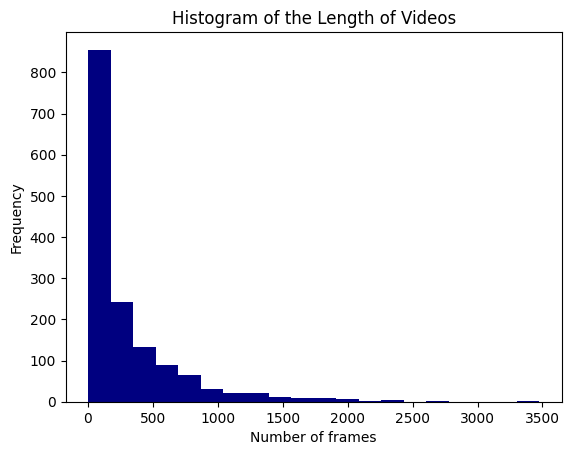

In [4]:
# Plot histogram of video lengths
plt.hist(video_lengths, bins=20, color='navy')
plt.title('Histogram of the Length of Videos')
plt.xlabel('Number of frames')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

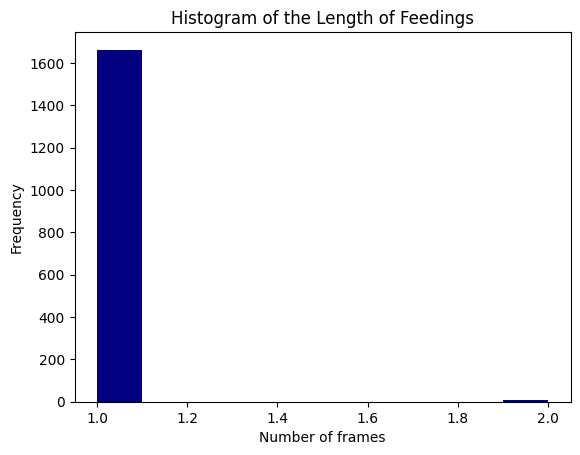

In [5]:
# Plot histogram of feeding lengths
plt.hist(feeding_lengths, bins=10, color='navy')
plt.title('Histogram of the Length of Feedings')
plt.xlabel('Number of frames')
plt.ylabel('Frequency')

In [6]:
# Display exact number of feeding lengths
from collections import Counter

feeding_length_counter = Counter(feeding_lengths)

print('Counter of feeding lengths')
for length, count in feeding_length_counter.items():
  print(length, 'frames:\t', count)

Counter of feeding lengths
1 frames:	 1663
2 frames:	 6


## Save a list of frames and lables

In [7]:
# All annotations (text files in the annotations directory).
all_videos = [file for file in os.listdir(annotations_dir) if file.endswith('.txt')]

In [19]:
# Find feeding frames
positive_clips = []

progress = 0
nr_videos = len(all_videos)

for filename in all_videos:
  file_path = os.path.join(annotations_dir, filename)

  data = np.loadtxt(file_path, dtype=int)

  # Finding indices of frames where the fish is feeding.
  feeding_indices = np.where(data[:,1] == 1)[0]

  if feeding_indices.size > 0:    # If there were any feeding frames.
    for index in feeding_indices:
      positive_clips.append(
          {
              'video' : filename,
              'frame' : index,
              'label' : 1
          }
      )

  progress += 1

  clear_output(wait=True)
  print(f'Progress: {progress/nr_videos*100:.2f}%')

Progress: 100.00%


In [20]:
# Select an equally large sample of non-feeding frames.
import random

# Set seed for reproducability.
random.seed(23)

negative_clips = []

nr_feeding_frames = len(positive_clips)

# Take a random sample of videos (with resampling).
sampled_videos = random.choices(all_videos, k=nr_feeding_frames)

failed_videos = []

progress = 0

for video in sampled_videos:
  failed = False

  annotation = np.loadtxt(f'{annotations_dir}/{video}')

  nr_frames = len(annotation)

  selected_index = random.randint(0, nr_frames-1)

  label = annotation[selected_index, 1]

  frame_dict = {
      'video' : video,
      'frame' : selected_index,
      'label' : label
  }

  tries = 0

  # Check if frame is a feeding frame or if it has been selected before.
  while label == 1 or frame_dict in negative_clips:
    selected_index = random.randint(0, nr_frames-1)   # Select new frame.

    label = annotation[selected_index, 1]

    frame_dict = {
        'video' : video,
        'frame' : selected_index,
        'label' : label
    }

    tries += 1

    if tries >= 100:
      failed = True
      failed_videos.append((video, selected_index, label))
      break

  if not failed:
    negative_clips.append(frame_dict)

  progress += 1

  clear_output(wait=True)
  print(f'Progress: {progress/nr_feeding_frames*100:.2f}%')

Progress: 100.00%


In [26]:
# Some samples might not be loaded as the selected videos can be too short to choose new frames from.
# If the difference in positive and negative samples is not larger than 10%, this will be accepted.
print(f'Number of negative samples which failed to load: {len(failed_videos)}')
print(f'Ratio of positive to negative class size: {len(negative_clips)/len(positive_clips)*100:.2f}%')

Number of negative samples which failed to load: 2
Ratio of positive to negative class size: 99.88%


In [22]:
clips = positive_clips + negative_clips

print('Total sample size:', len(clips))

Total sample size: 3348


In [23]:
# Compile dataframe of selected sample.
import pandas as pd

clips_df = pd.DataFrame(clips)

clips_df.head()

,video,frame,label
0,tracked_fish_clip_2_Jan_11_track_609.txt,780,1.0
1,tracked_fish_clip_2_Jan_11_track_593.txt,207,1.0
2,tracked_fish_clip_2_Jan_11_track_593.txt,258,1.0
3,tracked_fish_clip_2_Jan_11_track_593.txt,380,1.0
4,tracked_fish_clip_2_Jan_11_track_593.txt,500,1.0


In [24]:
print('Number of positive samples:', len(clips_df[clips_df['label'] == 1]))
print('Number of negative samples:', len(clips_df[clips_df['label'] == 0]))

Number of positive samples: 1675
Number of negative samples: 1673


In [25]:
# Save selected sample data.
clips_df.to_csv(f'{feeding_dir}/clips.csv', index=False)